### TODO:

**GRAFICOS**
- [X] criar grafico temporal
- [ ] criar grafico diario
- [X] criar distribuicoes de ganho
- [X] criar historico de dividendos
- [X] criar historico de lucro em vendas

**FUNCIONALIDADES**
- [ ] implementar preço açoes compradas no dia
- [ ] implementar subdivisao de acoes ao longo do tempo (qual valor usar?)
- [ ] como sera o input dos dados
- [ ] implementar interface com telegram
- [ ] implementar botoes para resultados especificos
- [X] implementar dividendos

In [1]:
import pandas as pd
import seaborn as sns
from pandas_datareader import data as web
from datetime import datetime
from matplotlib import pyplot as plt
import os
from dotenv import load_dotenv, find_dotenv
import dotenv

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../src/')


from stockz_ import *
from fiis_bot import *


In [58]:
#k = FiisBot().update_fiis_dividends()
st = Stockz()

Lendo o arquivo C:/Users/guilherme.bonaldo/Desktop/Stockz/data/raw/compras.xlsx
Buscando preco historico de ['ABEV3', 'ALZR11', 'AZUL4', 'BIDI4', 'CIEL3', 'ENBR3', 'HGLG11', 'ITSA4', 'KNRI11', 'LLIS3', 'VVAR3']


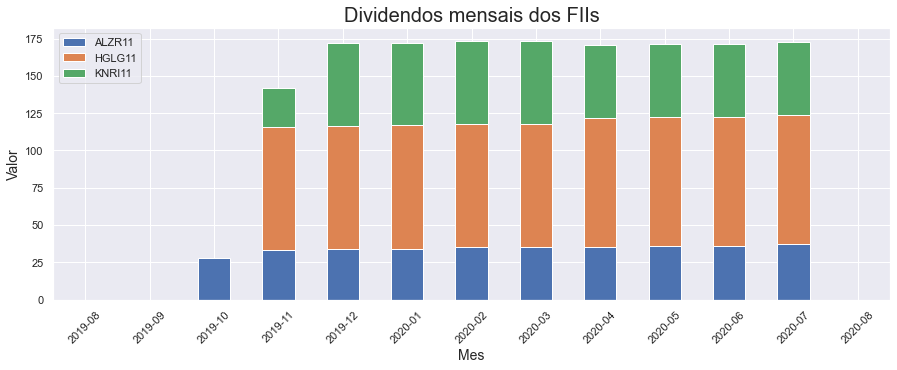

True

In [59]:
st.plot_FIIs_dividends()

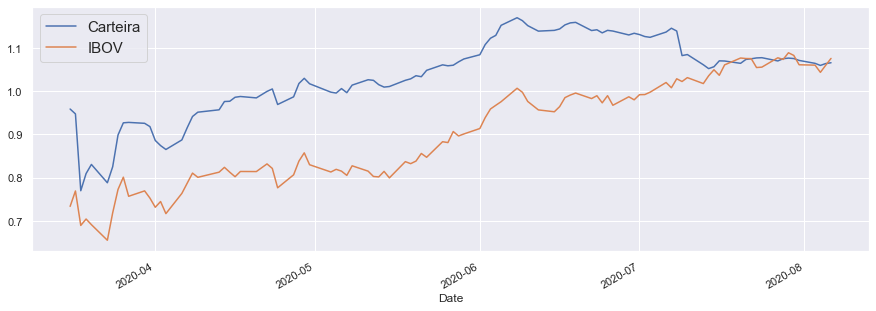

True

In [60]:
st.plot_historical_gains(100)

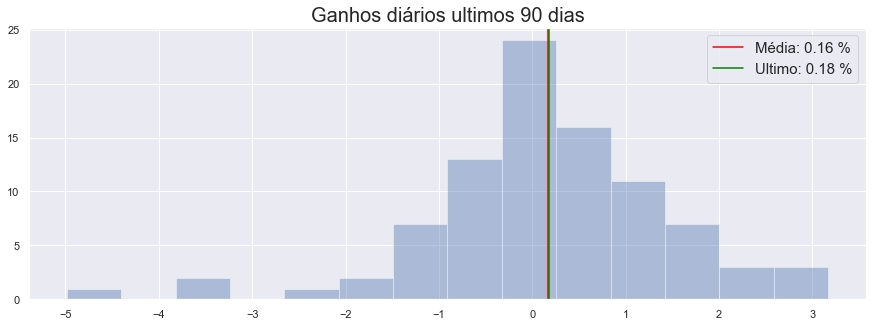

True

In [61]:
st.plot_daily_gains_distribution(90)

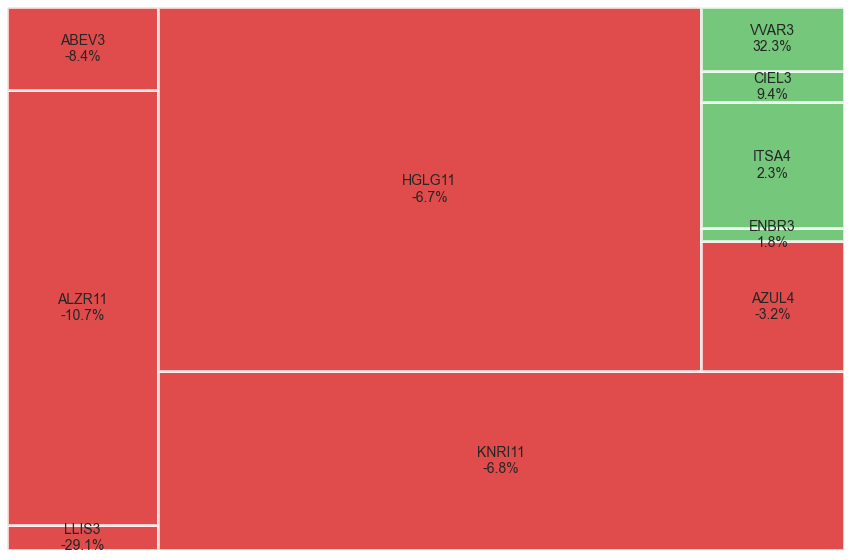

True

In [63]:
st.portfolio_tree_plot(30)

In [54]:
!conda env export > environment.yml

[autoreload of matplotlib failed: Traceback (most recent call last):
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\gui

[autoreload of matplotlib.artist failed: Traceback (most recent call last):
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Us

[autoreload of matplotlib.bezier failed: Traceback (most recent call last):
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Us

[autoreload of matplotlib.mlab failed: Traceback (most recent call last):
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\User

[autoreload of matplotlib.projections.polar failed: Traceback (most recent call last):
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\envs\stockz\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  